# ECSE 415 Final Project



## 1. Age Classification

### Sobel filter

In [47]:
import cv2
import numpy as np

class SB:
    def __init__(self):
        #self.img = img
        self.sobelX = None
        self.sobelY = None
        self.sb = None

    # use kernel to filter the input image
    def kernel_filter (self, kernel):
        height, width = self.img.shape
        kernel_height, kernel_width = kernel.shape

        img_pad = np.zeros(((height+2), (width+2)), np.float32)
        img_pad[1:height+1, 1:width+1] = self.img

        window = np.zeros((kernel_height, kernel_width), np.float32)
        value = np.zeros((kernel_height, kernel_width), np.float32)
        img_filter = np.zeros((height, width))

        for row in range(1, height):
            for col in range(1, width):
                window = img_pad[(row - 1): (row + 2), (col - 1): (col + 2)]
                value = window*kernel
                img_filter[row-1, col-1] = int(value.sum())

        return img_filter

    def filter(self):
        filterX = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        filterY = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        filterG = np.array([(1, 2, 1), (2, 4, 2), (1, 2, 1)], np.float32)/16
        sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

        self.sobelX = self.kernel_filter(filterX)
        self.sobelY = self.kernel_filter(filterY)
        
        
        sb = cv2.magnitude(self.sobelX, self.sobelY)
        self.sb = cv2.GaussianBlur(sb, (5,5), 0)
        #self.sb = cv2.filter2D(sb, -1, sharpen_kernel)
        #(self.sobelX**2 + self.sobelY**2)**0.5
        #self.sb = cv2.GaussianBlur(sb, (5,5), 0)

    def threshold(self, th):
        img_thr = np.copy(self.sb)
        img_thr[img_thr >= th] = 0
        img_thr[img_thr != 0] = 255

        self.sb = img_thr

    def sobel(self, img, th=130):
        self.img = img
        self.filter()
        self.threshold(th)
        return self.sb


In [48]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from openpyxl import load_workbook

# read data from directory and excel sheet
def getData():
    #import all images in the data set
    wb = load_workbook('../labels.xlsx')
    ws = wb.active

    images=[]
    labels = []
    count = 2
    path='../Faces'
    for root,dirs,files in os.walk(path):
        for image in files:
            if image.endswith((".jpg")):
                img = cv2.imread(root + "/" + image, 0)
                img = cv2.resize(img,(150,200))
                images.append(img)
                labels.append(ws.cell(row=count, column = 3).value)
                count += 1
    print('Number of images: ', len(images))
    print('Number of labels: ', len(labels))
    return np.array(images), np.array(labels)

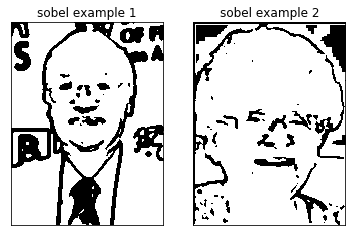

In [49]:
sb = SB()
sobel_img = []

for img in images[-5:]:
    sobel_img.append(sb.sobel(img))
    
plt.subplot(121), plt.imshow(sobel_img[3], cmap="gray")
plt.title("sobel example 1"),plt.xticks([]),plt.yticks([])    
plt.subplot(122), plt.imshow(sobel_img[2], cmap="gray")
plt.title("sobel example 2"),plt.xticks([]),plt.yticks([])
plt.show()    

---
## Stage 1. Location

[ 3  3  3  2  2  2  3  5  1  2  3  6  8  7  4  8 11 13 13  8  8 10  8  8  5
  0  0  0  7 19 27 29 30 28 31 30 27 18 15  5  2  0  1  3  6  6  0]
(47,)
[  1.8   2.2   2.6   2.4   2.4   2.8   2.6   2.6   2.8   3.4   4.    5.2
   5.6   6.6   7.6   8.6   9.8  10.6  10.6  10.4   9.4   8.4   7.8   6.2
   4.2   2.6   2.4   5.2  10.6  16.4  22.4  26.6  29.   29.6  29.2  26.8
  24.2  19.   13.4   8.    4.6   2.2   2.4   3.2   3.2   3.    2.4]
(47,)
[ -4.8  -3.2  -0.8  -0.4  -0.4  -0.4  -0.2  -0.8  -2.2  -3.8  -4.6  -4.8
  -5.   -5.4  -6.2  -6.2  -5.   -2.6   0.6   3.4   4.8   5.8   7.4   9.4
   9.    2.8  -9.  -22.  -31.2 -33.2 -28.6 -19.8  -9.8  -0.4   7.6  15.6
  23.6  29.6  30.6  25.6  16.8   7.    0.4  -1.6   0.2   4.    6.2]
(47,)
[  0.  17.  25.  33.  42.  43.]
[  0.    3.2  11.8   8.    2.    1.8]
25.0 33.0
[[   0    0   35   47 1215]
 [  24    0    3    9   20]
 [   7    6    3    2    4]
 [  26    9    7    6   24]
 [   7   12    9    9   44]
 [  18   15    2    2    4]
 [  24   16    6

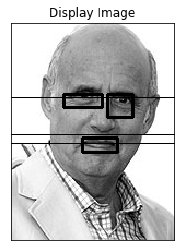

In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def eye_region(img):
    img = sb.sobel(img)
    height, width = img.shape
    h1, h2, w1, w2 = int(height/3), int(3*height/5), int(width/4), int(3*width/4)
    hist = np.zeros((h2-h1),dtype = np.uint8)

    for i in range(h1, h2):
        hist[i-h1] = (img[i,w1:w2] == 0).sum()
    center_line = hist.argmax()

    search_region = 255 - img[h1:h2, w1:w2]
    left,right = np.zeros(4), np.zeros(4)
    left_min, right_min = 99, 99
    i_left, i_right = 0, 0

    output = cv2.connectedComponentsWithStats(np.uint8(search_region), 8, cv2.CV_32S)
    stats = output[2]
    for i in range(1, stats.shape[0]):
        x_pos = stats[i,0] + int(stats[i,2]/2)
        y_pos = stats[i,1] + int(stats[i,3]/2)
        if stats[i,4] >= 30:
            #component is left eye
            if x_pos < ((w2-w1)/2):
                if abs(y_pos - center_line) < left_min:
                    left_min = abs(y_pos - center_line)
                    i_left = i
            #component is right eye
            if x_pos > ((w2-w1)/2):
                if abs(y_pos - center_line) < right_min:
                    right_min = abs(y_pos - center_line)
                    i_right = i
    left = stats[i_left, 0:4]
    left[0] += w1
    left[1] += h1
    right = stats[i_right, 0:4]
    right[0] += w1
    right[1] += h1

    return center_line+h1, left, right

def eye_detect(img_gray):
    sob = sb.sobel(img_gray)
    #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = img_gray.shape
    h1, h2, w1, w2 = int(height/3), int(3*height/5), int(width/4), int(3*width/4)
    hist = np.zeros((h2-h1),dtype = np.uint8)

    for i in range(h1, h2):
        hist[i-h1] = (sob[i,w1:w2] == 0).sum()
    center_line = hist.argmax()
    
    search_region = img_gray[h1:h2, w1:w2]
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
    eyes = eye_cascade.detectMultiScale(search_region)
    if len(eyes) < 2:
        center_line, left, right = eye_region(img_gray)
        center_line -= h1
    else:
        for i in range(0,len(eyes)):
            eyes[i][0] += w1
            eyes[i][1] += h1

        if eyes[0][0] < eyes[1][0]:
            left = eyes[0]
            right = eyes[1]
        else:
            left = eyes[1]
            right = eyes[0]
        
    return center_line+h1, left, right

def nose_mouth_loc(img_gray, l_eye, r_eye):
    height, width = img.shape
    Deyes = r_eye[0] + r_eye[2] - l_eye[0]
    y1 = l_eye[1] + l_eye[3]
    y2 = y1 + int(3*Deyes/4)
    x1 = l_eye[0] + int(l_eye[2]/2)
    x2 = x1 + Deyes - int(l_eye[2]/2) - int(r_eye[2]/2)
    hist = np.zeros((y2-y1),dtype = np.uint8)
    sob = sb.sobel(img_gray)

    if (y2 > 199) :
        y2 = 199
    for i in range(y1, y2):
        hist[i-y1] = (sob[i,x1:x2] == 0).sum()
    print(hist)
    print(hist.shape)
    kernel = np.ones(5)/5
    hist = np.convolve(hist, kernel, mode="same")
    print(hist)
    print(hist.shape)
    kernel2 = np.array([-1,-1,0,1,1])
    first_d = np.convolve(hist, kernel2, mode="same")
    print (first_d)
    print(first_d.shape)
    index = np.zeros(1)
    max = np.zeros(1)
    for i in range(0,first_d.shape[0]-1):
        if first_d[i] >= 0 and first_d[i+1] < 0:
            index = np.append(index,i)
            max = np.append(max,first_d[i] - first_d[i+1])
        elif first_d[i] < 0 and first_d[i+1] >= 0:
            index = np.append(index,i)
            max = np.append(max,first_d[i+1] - first_d[i])
    print(index)
    print(max)
    i = max.argmax()
    mouth = index[i]
    max[i] = 0
    i = max.argmax()
    nose = index[i]
    print (mouth,nose)
    
    if mouth < nose:
        temp = mouth
        mouth = nose
        nose = temp
    #print (mouth,nose)
    search_region = 255 - sob[y1:y2, x1:x2]
    min = 99
    output = cv2.connectedComponentsWithStats(np.uint8(search_region), 8, cv2.CV_32S)
    stats = output[2]
    print(stats)
    ind = 0
    for i in range(1, stats.shape[0]):
        y_pos = stats[i,1] + int(stats[i,3]/2)
        if stats[i,4] >= 50:
            if abs(y_pos - mouth) < min:
                min = abs(y_pos - mouth)
                ind = i
    mouth_region = stats[ind, 0:4]
    mouth_region[0] += x1
    mouth_region[1] += y1
    
    mouth += (y1)
    nose += (y1)
    
    return int(mouth), int(nose), mouth_region

img2 = cv2.imread("sample.jpg",0)
img2 = cv2.resize(img2, (150,200),)
histo = eye_region(img2)
#img2 = img.copy()
cv2.rectangle(img2,           
              (histo[1][0], histo[1][1]),                 # upper left corner
              (histo[1][0]+histo[1][2], histo[1][1]+histo[1][3]),        # lower right corner
              (0, 0, 255),                  # red
              2)
cv2.rectangle(img2,           
              (histo[2][0], histo[2][1]),                 # upper left corner
              (histo[2][0]+histo[2][2], histo[2][1]+histo[2][3]),        # lower right corner
              (0, 0, 255),                  # red
              2)

img4 = cv2.imread("sample.jpg",0)
img4 = cv2.resize(img4, (150,200),)
c,left,right = eye_detect(img4)

mouth,nose,mouth_region = nose_mouth_loc(img4,left,right)
img4[int(mouth),:] = 0
img4[int(nose),:] = 0
img4[c,:] = 0
cv2.rectangle(img4,(left[0],left[1]),(left[0]+left[2],left[1]+left[3]),(0,0,255),2)
cv2.rectangle(img4,(right[0],right[1]),(right[0]+right[2],right[1]+right[3]),(0,0,255),2)
cv2.rectangle(img4,(mouth_region[0],mouth_region[1]),(mouth_region[0]+mouth_region[2],mouth_region[1]+mouth_region[3]),(0,0,255),2)
#cv2.rectangle(img4,(x1,y1),(x2,y2),(0,0,255),2)

#plt.subplot(121), plt.imshow(img2, cmap="gray")
#plt.title("img2"),plt.xticks([]),plt.yticks([])
plt.subplot(111), plt.imshow(img4, cmap="gray")
plt.title("Display Image"),plt.xticks([]),plt.yticks([])
plt.show()

---
## 2. Feature Extraction

### 2.1 Wrinkle Feature

In [95]:
# Function used to calculate wrinkle density as per instructions
def wrinkle_density(img, threshold):
    Wa = np.sum(img >= threshold)
    Pa = img.shape[0] * img.shape[1]
    result = Wa/Pa
    return result

# Function used to calculate wrinkle depth as per instructions
def wrinkle_depth(img, threshold):
    Wa = img[img >= threshold]
    M = np.sum(Wa)
    result = M / (255*len(Wa))
    return result


# Function used to calculate average skin variance as per instructions
def avg_skin_variance(img):
    M = np.sum(img)
    Pa = img.shape[0] * img.shape[1]
    result = M / (255*Pa) 
    return result


# Function used to calculate the wrinkle features for the 5 different parts of the face: forehead, left eye, right eye, left cheek, right cheek
def wrinkle_features(img, threshold, eyes, left_eye, right_eye, mouth): 
    corner_left_eye = {}
    corner_right_eye = {}
    forehead = {}
    cheek_left = {}
    cheek_right = {}

    #Apply sobel to get wrinkled image
    sb = SB()
    wrinkled = sb.sobel(img)


    #Define the sections for each part of the face and calculate their wringle features 
    left_patch = left_eye[0] - max(left_eye[2], right_eye[2])//4
    right_patch = left_eye[0]
    top_patch = left_eye[1]
    bottom_patch = left_eye[1] + left_eye[3]
    window = wrinkled[top_patch:bottom_patch, left_patch:right_patch]
    corner_left_eye['density'] = wrinkle_density(window, threshold)
    corner_left_eye['depth'] = wrinkle_depth(window, threshold)
    corner_left_eye['variance'] = avg_skin_variance(window)


    left_patch = right_eye[0] + right_eye[2]
    right_patch = left_patch + max(left_eye[2], right_eye[2])//4
    top_patch = right_eye[1]
    bottom_patch = right_eye[1] + right_eye[3]
    window = wrinkled[top_patch:bottom_patch, left_patch:right_patch]
    corner_right_eye['density'] = wrinkle_density(window, threshold)
    corner_right_eye['depth'] = wrinkle_depth(window, threshold)
    corner_right_eye['variance'] = avg_skin_variance(window)

    left_for = mouth[0]
    right_for = mouth[0] + mouth[2]
    bottom_for = eyes - max(left_eye[3], right_eye[3])
    top_for = bottom_for - max(mouth[0]-left_eye[0], 
            right_eye[1]+right_eye[2]-mouth[0]-mouth[2]) 
    window = wrinkled[top_for:bottom_for, left_for:right_for]
    forehead['density'] = wrinkle_density(window, threshold)
    forehead['depth'] = wrinkle_depth(window, threshold)
    forehead['variance'] = avg_skin_variance(window)


    left_cheek_left = left_eye[0]
    left_cheek_right = left_cheek_left + (mouth[0] - left_eye[0])
    left_cheek_top = eyes + min(left_eye[3], right_eye[3])//4
    left_cheek_bottom = mouth[1]
    window = wrinkled[left_cheek_top:left_cheek_bottom, left_cheek_left:left_cheek_right]
    cheek_left['density'] = wrinkle_density(window, threshold)
    cheek_left['depth'] = wrinkle_depth(window, threshold)
    cheek_left['variance'] = avg_skin_variance(window)

    right_cheek_right = right_eye[0] + right_eye[2]
    right_cheek_left = right_cheek_right - (right_eye[0]+right_eye[2]-mouth[0]-mouth[2])
    right_cheek_top = eyes + min(left_eye[3], right_eye[3])//4
    right_cheek_bottom = mouth[1]
    window = wrinkled[right_cheek_top:right_cheek_bottom, right_cheek_left:right_cheek_right]
    cheek_right['density'] = wrinkle_density(window, threshold)
    cheek_right['depth'] = wrinkle_depth(window, threshold)
    cheek_right['variance'] = avg_skin_variance(window)

    return corner_left_eye, corner_right_eye, forehead, cheek_left, cheek_right

---
### 2.2 Geometric Feature  and HoG Feature

In [96]:
def geometric_feature(img, eyes, left_eye, right_eye, nose_pos, mouth_pos):
    # 1st geometric feature
    D_em = mouth_pos - eyes
    D_ee = (right_eye[0]+right_eye[2]//2) - (left_eye[0]+left_eye[2]//2)
    R_em = D_em / D_ee
    # 2nd geometric feature
    D_en = nose_pos - eyes
    D_nm = mouth_pos - nose_pos
    R_enm = D_en / D_nm
    return R_em, R_enm


In [97]:
def feature_extraction(img, eyes, left_eye, right_eye, nose_pos, mouth_pos, mouth):
    threshold = 40
    wrinkles = wrinkle_features(img, threshold, eyes, left_eye, right_eye, mouth)

    R_em, R_enm  = geometric_feature(img, eyes, left_eye, right_eye, nose_pos, mouth_pos)
    return wrinkles, R_em, R_enm


In [213]:
from sklearn.cluster import KMeans
from sklearn import svm

class SL:
    def __init__(self, num_words):
        self.K = num_words
        self.train_model = None  
        self.Kmean_model = None
    
    # set Kmean object with train dataset
    def set_Kmean(self, dataset):
        features =  np.reshape(dataset, (125, 15))
        features[np.isnan(features)] = 0
        km = KMeans(n_clusters=self.K, n_init=1).fit(features)
        self.Kmean_model = km
        
    # quantize each feature to its closest visual word in the dictionary
    def quantize(self, dataset):
        qtz = np.zeros((dataset.shape[0], self.K))  
        for i, data in enumerate(dataset):
            feats = self.Kmean_model.predict(data)
            hist, bin_edges = np.histogram(feats, bins=self.K)
            # normalize histogram
            qtz[i] = hist/np.sum(hist)
        return qtz
    
    # train the model
    def train(self, img_train, label_train):
        img_train =  np.reshape(img_train, (125, -1))
        img_train[np.isnan(img_train)] = 0
        self.set_Kmean(img_train)
        #img_train = self.quantize(img_train)
        clf = svm.LinearSVC()
        clf.fit(img_train, label_train.astype(int))
        self.train_model = clf
    
    # get accuracy using built in score function
    def accuracy(self, img_test, label_test):
        #img_test = self.quantize(img_test)
        img_test = np.reshape(img_test, (125, 15))
        img_test[np.isnan(img_test)] = 0
        acc = self.train_model.score(img_test, label_test.astype(int))
        return acc*100
    
    # show 5 images from each category
    def show(self, features, images, labels, categories):
        plot_pos = [[1,3,5,7,9], [2,4,6,8,10]]
        # 1   2
        # 3   4
        # 5   6
        # 7   8
        # 9   10   <- image position for matplot
        num_cat = len(categories)
        for i in range(num_cat):
            label_pos = []
            # find index of matched category and get first 5 images from that list
            for p, l in enumerate(labels):
                if l == i:
                    label_pos.append(p)
                if len(label_pos) == 5:
                    break
            feats = self.quantize(features[label_pos])
            plt.figure(figsize=(15,15))
            # now show 5 images with histogram by side
            for j, pos in enumerate(label_pos):
                histogram_img = feats[j]
                display_img = images[pos]
                plt.subplot(5, 2, plot_pos[1][j])
                plt.bar(np.arange(self.K), histogram_img, color = 'g')
                plt.subplot(5, 2, plot_pos[0][j])
                plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
                plt.title(categories[i]), plt.xticks([]), plt.yticks([])
        plt.show()

---
### Get features and Partition data

In [204]:
from sklearn.model_selection import train_test_split
import numpy

images, labels = getData()

WKS = []
GEO = []

for img in images:
    eyes,left_eye,right_eye = eye_detect(img)
    mouth_pos,nose_pos,mouth = nose_mouth_loc(img, left_eye,right_eye)
    wrinkles, R_em, R_enm = feature_extraction(img, eyes, left_eye, right_eye, nose_pos, mouth_pos, mouth)
    WKS.append(np.array(wrinkles).flatten())
    


Number of images:  254
Number of labels:  254
[14  9  2  0  0  0  0  0  0  0  0  0  0  1  2  1  1  3 10 20 22 24 24 22 17
 14 11  6  3  3 16 26 31 34 39 39 40 39 35 23 10  3  0  0  0  0  2  3]
(48,)
[  5.    5.    5.    2.2   0.4   0.    0.    0.    0.    0.    0.    0.2
   0.6   0.8   1.    1.6   3.4   7.   11.2  15.8  20.   22.4  21.8  20.2
  17.6  14.   10.2   7.4   7.8  10.8  15.8  22.   29.2  33.8  36.6  38.2
  38.4  35.2  29.4  22.   14.2   7.2   2.6   0.6   0.4   1.    1.    1. ]
(48,)
[-10.   -2.2   7.4   9.6   7.2   2.6   0.4   0.    0.   -0.2  -0.8  -1.4
  -1.6  -1.8  -3.6  -8.6 -15.6 -22.  -25.4 -24.2 -17.2  -6.2   4.6  12.6
  17.8  20.2  16.4   5.6  -9.  -22.6 -32.6 -36.4 -32.6 -23.6 -13.6  -3.2
  10.2  25.2  37.4  43.2  41.6  33.   20.4   8.4   1.2  -1.    0.4   2. ]
(48,)
[  0.   1.   8.  21.  27.  35.  44.  45.]
[  0.    9.6   0.2  10.8  14.6  13.4   2.2   1.4]
27.0 35.0
[[   0    0   40   48 1371]
 [  26    0   14    3   25]
 [  24   13    1    2    2]
 [  10   14   21 

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in longlong_scalars
  if __name__ == '__main__':


[ 0  0  0  0  0  0  1  1  0  0  2  7 10 18 19 19 15 14  9  4  2  2  2  2  1
 15 26 28 31 33 33 32 33 27 18 11  8  7  7  6]
(40,)
[  0.    0.    0.    0.    0.2   0.4   0.4   0.4   0.8   2.    3.8   7.4
  11.2  14.6  16.2  17.   15.2  12.2   8.8   6.2   3.8   2.4   1.8   4.4
   9.2  14.4  20.2  26.6  30.2  31.4  32.4  31.6  28.6  24.2  19.4  14.2
  10.2   7.8   5.6   4. ]
(40,)
[  0.    0.   -0.2  -0.6  -0.8  -0.6  -0.6  -2.   -5.  -10.  -15.8 -20.
 -19.6 -14.6  -6.4   3.4  12.2  17.2  17.4  14.8  10.8   3.8  -7.4 -19.4
 -28.4 -33.2 -33.2 -27.  -17.   -7.2   1.4  11.   20.4  26.6  28.4  25.6
  20.2  14.8  14.   13.4]
(40,)
[  0.   1.  14.  21.  29.]
[  0.    0.2   9.8  11.2   8.6]
21.0 14.0
[[  0   0  33  40 877]
 [ 22   6   1   2   2]
 [  9  11   7   5  29]
 [ 17  10  14  10  79]
 [  0  15  33  25 332]
 [  5  39   1   1   1]]
[ 3  3  3  3  3  3  3  3  4  4  4  6  5  2  0  0  1  0  1  2  3  6  7  7  7
  6  5  6  7 10  8  0  0  0  0  0  0  0  0]
(39,)
[ 1.8  2.4  3.   3.   3.   3.   3.2 

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
(40,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
(40,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
(40,)
[ 0.]
[ 0.]
0.0 0.0
[[  0   0   6  40 240]]
[ 0  0  0  4 10 11 12 10  2  0  0  0  0  0  0 10 14 16 17 14 12 16 13 10  7
  0  0  1  3  3  3  2  1  2  4  4]
(36,)
[  0.    0.8   2.8   5.    7.4   9.4   9.    7.    4.8   2.4   0.4   0.
   0.    2.    4.8   8.   11.4  14.2  14.6  15.   14.4  13.   11.6   9.2
   6.    3.6   2.2   1.4   2.    2.4   2.4   2.2   2.4   2.6   2.2   2. ]
(36,)
[ -3.6  -7.8 -11.6 -13.2 -10.6  -3.6   5.   11.2  13.2  11.4   7.2   0.8
  -6.4 -12.8 -17.4 -18.8 -16.  -10.2  -3.8   1.4   5.    8.6  12.2  15.
  15.   11.6   6.2   1.4  -1.2  -1.2  -0

[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0]
(56,)
[ 0.6  0.8  1.   1.   1.   1.   1.   1.   0.8  0.8  0.8  0.8  0.8  1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   0.8  0.8  0.8  0.8  0.8  1.   1.   0.8  0.6  0.4]
(56,)
[-1.8 -1.4 -0.6 -0.2  0.   0.   0.2  0.4  0.4  0.2  0.  -0.2 -0.4 -0.4 -0.2
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.2
  0.4  0.4  0.2  0.  -0.2 -0.4 -0.2  0.4  1.   1.4  1.4]
(56,)
[  0.   3.  10.  14.  48.  51.]
[ 0.   0.2  0.2  0.2  0.2  0.6]
51.0 3.0
[[ 0 10  1 46  3]
 [ 0  0  1 10 10]
 [ 0 11  1 37 37]
 [ 0 49  1  6  6]]


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in longlong_scalars
  """


[ 3  3  7 11 15 14 14 14 15 19 22 23 24 26 27 26 23 20 14 13  9  9 10  9  6
  7  7 11 15 17 13 12  8  9 18 33 35 37 37 32 22 14  8  9 10  8  9  7  4  4
  4  5 10 10  8  8]
(56,)
[  2.6   4.8   7.8  10.   12.2  13.6  14.4  15.2  16.8  18.6  20.6  22.8
  24.4  25.2  25.2  24.4  22.   19.2  15.8  13.   11.   10.    8.6   8.2
   7.8   8.    9.2  11.4  12.6  13.6  13.   11.8  12.   16.   20.6  26.4
  32.   34.8  32.6  28.4  22.6  17.   12.6   9.8   8.8   8.6   7.6   6.4
   5.6   4.8   5.4   6.6   7.4   8.2   7.2   5.2]
(56,)
[-12.6 -15.2 -14.8 -13.2 -10.2  -7.4  -6.2  -7.4  -9.6 -11.4 -11.8 -10.4
  -7.   -2.4   3.2   9.2  14.6  17.6  17.2  14.   10.2   7.2   5.    2.8
  -0.4  -4.6  -8.2  -9.   -6.   -0.8   2.4  -1.4 -11.8 -23.2 -30.4 -30.2
 -20.4  -2.6  15.8  27.8  31.4  28.6  21.   12.2   6.2   4.6   5.4   5.8
   3.8   0.   -3.6  -5.4  -3.4   1.6  10.4  15.4]
(56,)
[  0.  13.  23.  29.  30.  37.  49.  52.]
[  0.    5.6   3.2   3.2   3.8  18.4   3.6   5. ]
37.0 13.0
[[   0    0   40   56 14

[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
(56,)
[ 0.6  0.8  0.8  0.6  0.4  0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.2
  0.4  0.4  0.4  0.4  0.4  0.4  0.6  0.8  0.8  0.6  0.4  0.2  0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.2  0.4  0.6  0.8  1.   0.8
  0.6  0.4  0.2  0.   0.   0.   0.   0.   0.   0.   0. ]
(56,)
[-1.6 -0.8  0.4  1.   1.2  1.   0.6  0.2  0.   0.   0.   0.  -0.2 -0.6 -0.8
 -0.6 -0.2  0.   0.  -0.2 -0.6 -0.8 -0.4  0.4  1.   1.2  1.   0.6  0.2  0.
  0.   0.   0.   0.   0.   0.   0.  -0.2 -0.6 -1.  -1.2 -1.2 -0.8  0.   0.8
  1.2  1.2  1.   0.6  0.2  0.   0.   0.   0.   0.   0. ]
(56,)
[  0.   1.  11.  16.  18.  22.  36.  42.]
[ 0.   1.2  0.2  0.2  0.2  0.8  0.2  0.8]
1.0 22.0
[[ 0  4  1 52 41]
 [ 0  0  1  4  4]
 [ 0 16  1  2  2]
 [ 0 21  1  4  4]
 [ 0 41  1  5  5]]
[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 2 2 1 0 0 0
 0 0 0 0 0]
(42,)
[ 0.2  0.4  0.4  0.4  

[10  9 12 11 10 10 14 27 27 27 27 27 27 27 23 18 13 11  9  7  7  7  7  5  5
  4  3  2  1  1  1  7  5  4  3  3  2  1  0  0  0  0  0  0  3  4  2  2  2  2
  2]
(51,)
[  6.2   8.4  10.4  10.4  11.4  14.4  17.6  21.   24.4  27.   27.   27.
  26.2  24.4  21.6  18.4  14.8  11.6   9.4   8.2   7.4   6.6   6.2   5.6
   4.8   3.8   3.    2.2   1.6   2.4   3.    3.6   4.    4.4   3.4   2.6
   1.8   1.2   0.6   0.2   0.    0.    0.6   1.4   1.8   2.2   2.6   2.4
   2.    1.6   1.2]
(51,)
[-18.8 -14.6  -7.2  -7.  -11.2 -16.8 -19.6 -19.4 -15.4  -8.6  -1.8   3.4
   8.   13.2  17.4  19.6  19.   15.6  10.8   7.    4.8   3.8   3.6   4.2
   5.    5.2   4.8   2.8  -0.2  -2.8  -3.6  -3.   -1.2   1.6   4.    4.8
   4.2   3.6   2.8   1.8   0.2  -1.8  -3.2  -3.4  -2.8  -1.8  -0.4   1.2
   2.2   3.2   3.6]
(51,)
[  0.  10.  27.  32.  40.  46.]
[ 0.   5.2  3.   2.8  2.   1.6]
10.0 27.0
[[  0   0  27  51 946]
 [  1   0   2   1   2]
 [  0   0  27  38 408]
 [ 16  24   2   3   4]
 [  0  44   3   7  15]
 [  6  45   2

[ 0  0  0  0  9 10 14 14 13 11  6  5  3  0  0  0  8  9 11 13 14 14 13 11  5
  0  0  0  0  0]
(30,)
[  0.    0.    1.8   3.8   6.6   9.4  12.   12.4  11.6   9.8   7.6   5.
   2.8   1.6   2.2   3.4   5.6   8.2  11.   12.2  13.   13.   11.4   8.6
   5.8   3.2   1.    0.    0.    0. ]
(30,)
[ -1.80000000e+00  -5.60000000e+00  -1.04000000e+01  -1.42000000e+01
  -1.58000000e+01  -1.40000000e+01  -8.00000000e+00  -3.55271368e-15
   7.00000000e+00   1.14000000e+01   1.36000000e+01   1.30000000e+01
   8.80000000e+00   2.20000000e+00  -4.60000000e+00  -1.00000000e+01
  -1.36000000e+01  -1.42000000e+01  -1.14000000e+01  -6.80000000e+00
  -1.20000000e+00   5.20000000e+00   1.16000000e+01   1.54000000e+01
   1.58000000e+01   1.34000000e+01   9.00000000e+00   4.20000000e+00
   1.00000000e+00   0.00000000e+00]
(30,)
[  0.   7.  13.  20.]
[ 0.   7.   6.8  6.4]
7.0 13.0
[[  0   0  21  30 447]
 [  5   4  16   9  85]
 [  6  16  15   9  98]]
[4 3 3 3 3 3 3 3 3 3 3 4 4 3 4 4 6 6 6 6 4 3 3 3]
(24,)
[ 2.   2

[ 2  1  0  0  0  0  0  1  2  2  3  3  3  4  6  9 12 15 13  9 11 11 13 12  7
  2  2  2  1  9 25 25 29 28 23 15  7  7  5  4]
(40,)
[  0.6   0.6   0.6   0.2   0.    0.2   0.6   1.    1.6   2.2   2.6   3.
   3.8   5.    6.8   9.2  11.   11.6  12.   11.8  11.4  11.2  10.8   9.
   7.2   5.    2.8   3.2   7.8  12.4  17.8  23.2  26.   24.   20.4  16.
  11.4   7.6   4.6   3.2]
(40,)
[ -1.2  -0.2   1.    1.    0.   -1.4  -2.4  -3.   -3.2  -3.   -3.   -4.
  -6.2  -9.2 -11.4 -10.8  -7.6  -3.6  -0.6   1.    1.8   3.4   6.4   9.8
  12.   10.2   1.2 -12.4 -24.2 -30.  -29.  -19.8  -3.4  12.8  22.6  25.4
  24.2  19.6  15.8  12.2]
(40,)
[  0.   1.   4.  18.  26.  32.]
[  0.    1.2   1.4   1.6  13.6  16.2]
32.0 26.0
[[  0   0  32  40 957]
 [ 16   0   2   2   3]
 [  6   7  16  19 133]
 [ 24  17   1   2   2]
 [ 30  23   2   6   8]
 [  3  29  29  11 177]]
[2 2 2 1 2 2 1 2 7 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
(38,)
[ 1.2  1.4  1.8  1.8  1.6  1.6  2.8  3.2  2.8  2.6  2.2  0.8  0.   0.

[ 0  0  0  0  0  0  0  0  0  0  0  2 10 13 12  9  4  0  0  0  0  0  0  0  0
  2 18 33 34 34 33 31  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(48,)
[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.4   2.4   5.
   7.4   9.2   9.6   7.6   5.    2.6   0.8   0.    0.    0.    0.    0.4
   4.   10.6  17.4  24.2  30.4  33.   27.4  20.6  13.8   7.2   1.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
(48,)
[  0.    0.    0.    0.    0.    0.    0.   -0.4  -2.8  -7.4 -12.  -13.8
 -11.4  -4.8   4.   11.2  13.8  11.8   7.6   3.4   0.8  -0.4  -4.4 -14.6
 -27.6 -37.2 -40.  -35.4 -18.8   6.6  29.   39.4  39.8  33.4  21.    8.2
   1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
(48,)
[  0.   6.  13.  20.  28.]
[  0.    0.4   8.8   1.2  25.4]
28.0 13.0
[[   0    0   39   48 1632]
 [  26   11    6    5   21]
 [  13   12    7    5   29]
 [   4   25   34    8  190]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 4 6 6 3 3 2 0 0 

[ 0  0  0  0  0  0  2  3 14 19 20 21 14  8  6  4  0  0  0  0  6 14 23 30 36
 32 16  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  3  4  4  6]
(47,)
[  0.    0.    0.    0.    0.4   1.    3.8   7.6  11.6  15.4  17.6  16.4
  13.8  10.6   6.4   3.6   2.    0.8   1.2   4.    8.6  14.6  21.8  27.
  27.4  23.6  17.8  10.6   4.2   1.    0.2   0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.2   0.8   1.6   2.4   3.6   3.4   2.8]
(47,)
[  0.    0.   -0.4  -1.4  -4.8 -11.  -17.8 -22.2 -21.6 -14.8  -3.2   8.6
  17.   20.2  18.8  14.2   8.    0.4  -9.8 -21.2 -31.2 -36.2 -31.2 -14.6
   7.4  26.   36.2  36.2  27.2  14.6   5.2   1.2   0.2   0.    0.    0.
   0.    0.   -0.2  -1.   -2.4  -3.8  -5.   -4.6  -2.2   3.2   7. ]
(47,)
[  0.   1.  10.  17.  23.  37.  44.]
[  0.    0.4  11.8  10.2  22.    0.2   5.4]
23.0 10.0
[[   0    0   39   47 1542]
 [   3    6   16   10   81]
 [  21    8    8    5   30]
 [   0   20   27    9  117]
 [  29   21   10    6   45]
 [   0   42    5    5   16]
 [  37  

[ 3  3  4  5  6  6  7  6  5  7  7  7  6  7  6  6  6  7 11 14  7  5  2  3  3
  2  3  8 24 26 25 24 21 19 17 13 10  2  0]
(39,)
[  2.    3.    4.2   4.8   5.6   6.    6.    6.2   6.4   6.4   6.4   6.8
   6.6   6.4   6.2   6.4   7.2   8.8   9.    8.8   7.8   6.2   4.    3.
   2.6   3.8   8.   12.6  17.2  21.4  24.   23.   21.2  18.8  16.   12.2
   8.4   5.    2.4]
(39,)
[ -7.2  -7.   -5.4  -4.4  -3.   -1.8  -1.   -0.8  -0.6  -0.6  -0.6  -0.2
   0.6   0.8  -0.6  -3.4  -5.2  -4.2  -0.6   3.8   7.6   9.6   8.4   3.8
  -4.8 -15.  -23.4 -26.8 -24.8 -17.2  -5.6   5.4  12.2  16.   19.4  21.4
  20.8  18.2  13.4]
(39,)
[  0.  11.  13.  18.  23.  30.]
[  0.    0.8   1.4   4.4   8.6  11. ]
30.0 23.0
[[  0   0  30  39 827]
 [  1   0  23  38 280]
 [ 24   2   5  18  44]
 [ 25  26   5   6  19]]
[ 0  0  0  0  3  4  4  6 10 16 17 15 14 14  8  6  6  6  4  4 15 22 23 28 27
 27 26 26 26 26 24 22 20 16  4  0  0  0  0  0]
(40,)
[  0.    0.    0.6   1.4   2.2   3.4   5.4   8.   10.6  12.8  14.4  15.2
  13.6  11

[ 8  5  3  3  3  3  3  3  3  3  4  4  3  3  3  3  3  3  2  2  2  2  2  2  2
  2  2  2  9 12 16 21 29 33 36 33 29 27 22 15  7  4  5  6  7  8  9  9 10 10
 11]
(51,)
[  3.2   3.8   4.4   3.4   3.    3.    3.    3.    3.2   3.4   3.4   3.4
   3.4   3.2   3.    3.    2.8   2.6   2.4   2.2   2.    2.    2.    2.
   2.    2.    3.4   5.4   8.2  12.   17.4  22.2  27.   30.4  32.   31.6
  29.4  25.2  20.   15.   10.6   7.4   5.8   6.    7.    7.8   8.6   9.2
   9.8   8.    6.2]
(51,)
[ -8.2  -4.6   0.6   2.2   1.8   0.4  -0.2  -0.6  -0.8  -0.6  -0.2   0.2
   0.6   0.8   0.8   0.8   1.    1.2   1.2   1.    0.6   0.2   0.    0.
  -1.4  -4.8  -9.6 -14.8 -20.6 -26.  -29.  -28.  -22.8 -14.4  -3.6   7.8
  18.4  26.   29.   27.2  21.8  13.8   5.   -1.6  -4.6  -4.8  -4.2  -1.4
   3.6  12.8  17.8]
(51,)
[  0.   1.   5.  10.  23.  34.  42.  47.]
[  0.    5.2   0.6   0.4   1.4  11.4   6.6   5. ]
34.0 42.0
[[   0    0   57   51 2456]
 [   0    0   15   51  177]
 [  52    0    5    2    7]
 [  17   28   38 

[ 0  0  0  0  0  0  0  0  4  9 10  9  8  2  0  0  0  0  0  0  0  0  1 10 14
 17 18 11  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
(42,)
[  0.    0.    0.    0.    0.    0.    0.8   2.6   4.6   6.4   8.    7.6
   5.8   3.8   2.    0.4   0.    0.    0.    0.    0.2   2.2   5.    8.4
  12.   14.   13.   10.2   6.8   3.2   1.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0. ]
(42,)
[  0.    0.    0.    0.   -0.8  -3.4  -7.2 -10.2 -11.   -8.4  -2.4   4.8
   9.8  11.    9.2   5.8   2.4   0.4  -0.2  -2.4  -7.2 -13.2 -18.  -18.8
 -13.6  -2.8   9.   17.   19.   16.   10.    4.2   1.    0.    0.    0.
   0.    0.    0.    0.    0.    0. ]
(42,)
[  0.   3.  10.  17.  25.]
[  0.    0.8   7.2   0.6  11.8]
25.0 10.0
[[   0    0   31   42 1184]
 [  10    8    6    5   25]
 [  21    9    4    5   17]
 [   2   23    9    6   32]
 [  19   22   12    6   44]]
[ 0  0  0  0  0  0  0  0  0  0  1  9 12 14 14 12 12 10  6  6  0  0  0  0  0
  0  0  0  6 14 14 13 12 15 17 21 25 21 18  3  0  0  0 

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7 11 12 10  1  2  0  0  0
  0  0  0  0 15 22 27 39 38 30 23 16 22 16  8  0  0  1  4  1  0  0  0  0]
(49,)
[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    1.4   3.6   6.    8.    8.2   7.2   5.    2.6   0.6   0.4
   0.    0.    0.    3.    7.4  12.8  20.6  28.2  31.2  31.4  29.2  25.8
  21.4  17.   12.4   9.2   5.    2.6   1.2   1.2   1.2   1.    0.2   0.
   0. ]
(49,)
[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  -1.4  -5.   -9.6 -12.6 -11.2  -5.8   1.8   8.6  12.2  11.2   7.2   3.2
   1.   -2.6 -10.4 -20.2 -30.4 -38.4 -39.2 -29.2 -11.8   4.4  15.4  22.2
  25.6  25.6  24.2  21.8  17.8  11.8   5.2   1.6   1.2   2.2   2.2   1.2
   0.2]
(49,)
[  0.  11.  17.  24.  32.]
[  0.    1.4   7.6   3.6  16.2]
32.0 17.0
[[   0    0   40   49 1655]
 [  13   16    5    4   16]
 [  22   16    8    4   24]
 [  20   20    2    2    3]
 [   1   29   39   11  255]
 [  21   30    1    1    1

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 11  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(49,)
[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.2  3.6  3.6  3.6  3.6
  1.4  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0. ]
(49,)
[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.  -2.2 -5.8 -7.2 -5.  -1.4  2.2  5.8
  7.2  5.   1.4  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0. ]
(49,)
[  0.  22.  27.]
[ 0.   2.2  3.6]
27.0 22.0
[[   0    0   42   49 2040]
 [   8   27    5    2    7]
 [  31   27    7    2   11]]
[ 0  0  0  0  0  0  0  0  0  0  0  1  3  4  3  3  3  0  0  0  0  1  3 17 37
 36 34 15 17 20 19  4  0  0  0  0  1  1  2  2  3  3  4  4  4  5  6]
(47,)
[  0.    0.    0.    0.    0.    0.    0.    0.    0.    

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  5  2  2  1  1  1  2  2  1
  1  1  3 12 16  6  4  0  7 12 18 17  2  0  0  0  0  0  0  0  0  0  0]
(48,)
[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    1.    2.    2.4   2.8   3.    2.2   1.4   1.4   1.4   1.4   1.4
   1.4   1.6   3.6   6.6   7.6   8.2   7.6   6.6   5.8   8.2  10.8  11.2
   9.8   7.4   3.8   0.4   0.    0.    0.    0.    0.    0.    0.    0. ]
(48,)
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.00000000e+00
  -3.00000000e+00  -4.40000000e+00  -4.20000000e+00  -2.80000000e+00
  -8.00000000e-01   1.60000000e+00   3.00000000e+00   2.40000000e+00
   8.00000000e-01  -2.22044605e-16   0.00000000e+00  -2.00000000e-01
  -2.40000000e+00  -7.40000000e+00  -1.12000000e+01  -1.06000000e+01
  -5.60000000e+00   0.00000000e+00   3.40000000e+00   1.80000000e+

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  5 25 27 16  9  9  7  1  0  0  0  0  0  0  0  1  2  3  4  7]
(45,)
[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
   6.   11.4  14.6  16.4  17.2  13.6   8.4   5.2   3.4   1.6   0.2   0.
   0.    0.    0.2   0.6   1.2   2.    3.4   3.2   2.8]
(45,)
[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.   -1.   -7.  -17.4
 -25.  -24.  -16.2  -4.8   9.   20.   22.2  17.   11.8   8.4   5.    1.8
   0.   -0.8  -1.8  -3.   -4.6  -4.8  -2.8   2.6   6.6]
(45,)
[  0.  20.  27.  36.  42.]
[  0.    1.   13.8   0.8   5.4]
27.0 42.0
[[   0    0   37   45 1549]
 [   8   25   27    8   99]
 [   0   40    7    5   17]]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  3  0  0  0  0
  0  7 21 38 38 27  9  8  8 15 14 10 10 11 19 19 15  6  0  0  0  1  

[ 0  0  0  2  2  2  6 14 18 15  3  1  0  0  0  0  0  2 16 20 32 30 31 27 23
 16  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(44,)
[  0.    0.4   0.8   1.2   2.4   5.2   8.4  11.   11.2  10.2   7.4   3.8
   0.8   0.2   0.    0.4   3.6   7.6  14.   20.   25.8  28.   28.6  25.4
  19.8  13.6   8.2   3.6   0.4   0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0. ]
(44,)
[ -1.2  -2.   -3.2  -6.4 -11.6 -15.8 -14.6  -7.8   1.8  11.   16.8  16.6
  11.    4.2  -3.  -11.  -21.2 -30.  -34.6 -32.2 -22.6  -8.2   8.6  23.2
  32.2  33.4  29.4  21.4  11.8   4.    0.4   0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0. ]
(44,)
[  0.   7.  13.  21.]
[  0.    9.6   7.2  16.8]
21.0 7.0
[[   0    0   34   44 1234]
 [  10    3   20    9   63]
 [   0   17   34   10  197]
 [  33   24    1    2    2]]
[ 0  2  1  1  4  4 11 25 26 26 26 26 25 22 19 12 12 15 18 17 11 14 16 26 29
 29 29 29 30 29 16  4  8 14 21 19 18 16 14]
(39,)
[  0.6   0.8   

[ 1  3  2  7 13 17 17 11  6  4  2  0  0  0  0  0  0  2  5 10 10  7  4  0  0
  2  3  3  3  4  4  4  4  4  4  4  4  5  4  3  3  2  1  1  0]
(45,)
[  1.2   2.6   5.2   8.4  11.2  13.   12.8  11.    8.    4.6   2.4   1.2
   0.4   0.    0.    0.4   1.4   3.4   5.4   6.8   7.2   6.2   4.2   2.6
   1.8   1.6   2.2   3.    3.4   3.6   3.8   4.    4.    4.    4.    4.2
   4.2   4.    3.8   3.4   2.6   2.    1.4   0.8   0.4]
(45,)
[ -7.8 -12.4 -15.8 -16.4 -12.2  -4.2   5.2  13.2  16.8  15.4  11.    6.6
   3.6   1.2  -1.4  -4.8  -8.4 -10.4  -9.2  -4.6   1.8   7.2   9.    7.
   3.   -0.8  -3.   -3.2  -2.2  -1.4  -1.   -0.6  -0.2  -0.2  -0.4  -0.2
   0.4   1.2   2.2   3.2   3.8   3.8   3.4   3.    2.2]
(45,)
[  0.   5.  13.  19.  24.  35.]
[ 0.   9.4  2.6  6.4  3.8  0.6]
5.0 19.0
[[   0    0   39   45 1572]
 [  16    0    8    8   33]
 [  26    3   13    8   50]
 [  10   17    8    6   33]
 [  28   19    3    2    5]
 [   0   25    8   19   62]]
[ 0  0  0  0  4  7  9  9 11 11 10 12 14 16 12  6  4  

[ 7  5  8  7  2  0  0  0  0  0  0  0  0  1  3  4  3  2  2 10 13 13 10  9 10
  0  0  0  0  0  0  2  2  0  0  0  6  8 11 15 14 12 12 14  4  0  0  0  0  0
  0]
(51,)
[  4.    5.4   5.8   4.4   3.4   1.8   0.4   0.    0.    0.    0.    0.2
   0.8   1.6   2.2   2.6   2.8   4.2   6.    8.    9.6  11.   11.    8.4
   5.8   3.8   2.    0.    0.    0.4   0.8   0.8   0.8   0.8   1.6   2.8
   5.    8.   10.8  12.   12.8  13.4  11.2   8.4   6.    3.6   0.8   0.
   0.    0.    0. ]
(51,)
[-11.2  -6.2   1.6   6.    8.    7.4   5.2   2.2   0.4  -0.2  -1.   -2.4
  -3.6  -3.8  -3.   -3.2  -5.4  -8.6 -10.6 -10.4  -8.   -1.8   6.4  12.4
  13.6  12.2   9.6   5.4   0.8  -1.6  -1.2  -0.4  -0.8  -2.8  -6.2 -10.6
 -14.4 -15.  -11.8  -7.4  -1.8   5.2  11.8  15.   15.2  13.6   9.6   4.4
   0.8   0.    0. ]
(51,)
[  0.   1.   8.  21.  28.  40.]
[ 0.   7.8  0.6  8.2  2.4  7. ]
21.0 1.0
[[   0    0   47   51 2188]
 [   8    0   13    5   22]
 [  38    2    5    2    6]
 [  46    4    1    1    1]
 [   4   13    4 

[ 4  6 14 17 18 14  9  4  7  9  7  2  0  0 16 28 32 34 11  8 10 14 17 27 23
 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(46,)
[  4.8   8.2  11.8  13.8  14.4  12.4  10.4   8.6   7.2   5.8   5.    3.6
   5.    9.2  15.2  22.   24.2  22.6  19.   15.4  12.   15.2  18.2  18.6
  15.8  12.4   7.    2.4   0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
(46,)
[-20.  -20.8 -15.2  -6.8   2.8   9.2  11.    9.8   8.2   7.2   4.4  -3.4
 -15.8 -28.6 -32.  -22.4  -4.4  11.8  19.4  14.4   1.   -9.4  -7.2   5.2
  17.4  25.   25.8  19.4   9.4   2.4   0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
(46,)
[  0.   3.  10.  16.  20.  22.]
[  0.    9.6   7.8  16.2  10.4  12.4]
16.0 22.0
[[   0    0   35   46 1267]
 [   0    0    2    6   10]
 [  29    0    6   10   35]
 [   8    2    8   10   41]
 [  22    2    6    5   24]
 [   6    4    1    1    1]
 [   0   14   35   12  232]]
[10 

[ 2  0  0  0  0  0  0  2  0  0  0  2  4  5  6  4  5  4  5 14 16 16  9  4  3
  1  0  0  0  0  0  0  1  3 16 25 37 37 37 37 36 32 28 19 15  4]
(46,)
[  0.4   0.4   0.4   0.    0.    0.4   0.4   0.4   0.4   0.8   1.2   2.2
   3.4   4.2   4.8   4.8   4.8   6.4   8.8  11.   12.   11.8   9.6   6.6
   3.4   1.6   0.8   0.2   0.    0.    0.2   0.8   4.    9.   16.4  23.6
  30.4  34.6  36.8  35.8  34.   30.4  26.   19.6  13.2   7.6]
(46,)
[ -0.8   0.    0.8   0.4  -0.4  -0.8  -0.4  -0.4  -1.2  -2.6  -4.4  -5.6
  -5.6  -4.   -2.   -2.2  -5.6 -10.2 -11.8  -8.6  -1.6   6.8  13.8  16.4
  13.8   9.    4.8   2.4   0.8  -0.8  -4.8 -12.8 -24.4 -35.2 -41.  -39.6
 -31.4 -18.6  -4.8   7.   16.2  24.2  31.6  35.6  38.   32.8]
(46,)
[  0.   0.   3.  20.  28.  38.]
[  0.    0.8   0.8   8.4   1.6  11.8]
38.0 20.0
[[   0    0   37   46 1273]
 [  30    0    2    1    2]
 [  35    7    2    1    2]
 [  28   11    9   15   70]
 [   3   14    1    1    1]
 [   7   16    1    1    1]
 [   9   19    9    4   26]
 [ 

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  2  6  9 10 11 10 12 13 16 21 29 36
 33 29 23 17 15 12  3  2  3  5 24 39 42 43 39 19 13  5  0  0  0  0  0  0  0
  0  0  0  0]
(54,)
[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.4
   1.6   3.4   5.4   7.6   9.2  10.4  11.2  12.4  14.4  18.2  23.   27.
  29.6  30.   27.6  23.4  19.2  14.    9.8   7.    5.    7.4  14.6  22.6
  30.6  37.4  36.4  31.2  23.8  15.2   7.4   3.6   1.    0.    0.    0.
   0.    0.    0.    0.    0.    0. ]
(54,)
[  0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.4  -2.   -5.
  -8.4 -11.  -11.8 -10.8  -8.6  -6.8  -7.2 -11.  -17.6 -23.2 -24.  -18.4
  -7.6   5.6  17.   24.4  27.2  25.8  21.2  11.4  -5.2 -25.2 -40.8 -46.
 -36.6 -14.4  13.   34.8  45.   44.   34.4  21.6  11.    4.6   1.    0.
   0.    0.    0.    0.    0.    0. ]
(54,)
[  0.   8.  24.  31.  37.]
[  0.    0.4  13.2  16.6  27.4]
37.0 31.0
[[   0    0   46   54 1943]
 [   2   13   44   29  335]
 [   2   35   39    8  204]
 [   0  

[0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(56,)
[ 0.   0.2  0.4  0.6  0.8  0.8  0.6  0.6  0.4  0.2  0.2  0.2  0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.2  0.4  0.6  0.8  0.8  0.6  0.4  0.2  0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
(56,)
[-0.6 -1.  -1.2 -1.  -0.4  0.2  0.6  0.8  0.8  0.6  0.4  0.4  0.4  0.2  0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  -0.2 -0.6 -1.  -1.2 -1.  -0.4  0.4  1.   1.2  1.   0.6  0.2
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
(56,)
[  0.   4.  32.  38.]
[ 0.   0.6  0.2  0.8]
38.0 4.0
[[ 0  0  1 56 47]
 [ 0  3  1  4  4]
 [ 0  9  1  1  1]
 [ 0 37  1  4  4]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(30,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  2  2
  4  4  6  7  9 11 16 21 29 28 24 21 19 14 15 14 12  9  0  0  0  0  0  0  0
 16 23 22 27 30 31]
(56,)
[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.2   0.4   0.8   1.2   1.6   2.2
   2.8   3.6   4.6   6.    7.4   9.8  12.8  17.2  21.   23.6  24.6  24.2
  21.2  18.6  16.6  14.8  12.8  10.    7.    4.2   1.8   0.    0.    0.
   3.2   7.8  12.2  17.6  23.6  26.6  22.   17.6]
(56,)
[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.   -0.2  -0.6  -1.2  -1.8  -2.2  -2.6  -3.   -3.6
  -4.4  -5.6  -7.   -9.  -12.  -16.6 -21.  -22.  -18.2 -10.6  -0.8   8.4
  13.6  14.   12.2  12.4  14.4  16.4  16.8  15.2  11.2   6.   -1.4 -11.
 -20.  -26.6 -30.2 -30.2 -18.8   1.6  32.6  48.6]
(56,)
[  0.  15.  34.  45.  52.]
[  0.    0.2   9.2   7.4  20.4]
52.0 34.0
[[   0    0   50   56 2380]
 [  25   20    2    6    9]
 [   

[ 4  2  0  0  1  0  0  0  0  0  0  0  2  2  1  0  0  0  2  3  3  6  5  5  0
  0  4 11 17 16 15 11  9  7 10 11 19 20 21 26 38 38 36 32 30 19  6  0  0  0
  0  0  0]
(53,)
[  1.2   1.2   1.4   0.6   0.2   0.2   0.2   0.    0.    0.    0.4   0.8
   1.    1.    1.    0.6   0.6   1.    1.6   2.8   3.8   4.4   3.8   3.2
   2.8   4.    6.4   9.6  12.6  14.   13.6  11.6  10.4   9.6  11.2  13.4
  16.2  19.4  24.8  28.6  31.8  34.   34.8  31.   24.6  17.4  11.    5.
   1.2   0.    0.    0.    0. ]
(53,)
[ -2.6  -0.8   1.6   2.2   1.6   0.6   0.4   0.4  -0.2  -1.2  -1.8  -1.6
  -0.8   0.2   0.8   0.4  -1.   -3.2  -5.   -5.6  -3.8  -0.4   2.2   1.4
  -3.4 -10.  -15.4 -16.2 -11.6  -3.    4.6   7.6   4.4  -2.6  -9.6 -14.8
 -19.6 -23.8 -24.8 -21.6 -15.4  -5.4  10.2  26.8  37.4  39.6  35.8  27.2
  16.    6.2   1.2   0.    0. ]
(53,)
[  0.   1.   7.  12.  15.  21.  23.  29.  32.  41.]
[  0.    2.4   0.6   1.    1.4   2.6   4.8   7.6   7.   15.6]
41.0 29.0
[[   0    0   43   53 1847]
 [  14    0    1    

[ 0  0  0  0  1  5  7 14 23 15  7  7 14 22 19  5  4  5  6  6  8  8  9  8  8
  8  7  7  9 12 14 16 17 14 15]
(35,)
[  0.    0.    0.2   1.2   2.6   5.4  10.   12.8  13.2  13.2  13.2  13.
  13.8  13.4  12.8  11.    7.8   5.2   5.8   6.6   7.4   7.8   8.2   8.2
   8.    7.6   7.8   8.6   9.8  11.6  13.6  14.6  15.2  12.4   9.2]
(35,)
[ -2.00000000e-01  -1.40000000e+00  -3.80000000e+00  -7.80000000e+00
  -1.40000000e+01  -1.90000000e+01  -1.80000000e+01  -1.10000000e+01
  -3.60000000e+00  -2.00000000e-01  -4.00000000e-01  -8.00000000e-01
  -1.77635684e-15   3.00000000e+00   8.40000000e+00   1.32000000e+01
   1.28000000e+01   6.40000000e+00  -1.00000000e+00  -4.20000000e+00
  -3.60000000e+00  -2.40000000e+00  -1.00000000e+00   4.00000000e-01
   1.00000000e+00  -2.00000000e-01  -2.80000000e+00  -6.00000000e+00
  -8.80000000e+00  -9.80000000e+00  -8.40000000e+00  -2.40000000e+00
   6.60000000e+00   2.06000000e+01   2.76000000e+01]
(35,)
[  0.  12.  17.  22.  24.  31.]
[ 0.   3.   7.4  1.4  1.

[ 7  8  9  6  5  6  9  6  8 12 15 18 21 24 25 26 24 16 17 20 20 21 20 18 11
 12 12 11 11  8  7  7  8 13  6  0  0  3  5  7  3  0  0  0  3  9 10 11 11  9
 11 17 20 18 12 10]
(56,)
[  4.8   6.    7.    6.8   7.    6.4   6.8   8.2  10.   11.8  14.8  18.
  20.6  22.8  24.   23.   21.6  20.6  19.4  18.8  19.6  19.8  18.   16.4
  14.6  12.8  11.4  10.8   9.8   8.8   8.2   8.6   8.2   6.8   5.4   4.4
   2.8   3.    3.6   3.6   3.    2.    1.2   2.4   4.4   6.6   8.8  10.
  10.4  11.8  13.6  15.   15.6  15.4  12.    8. ]
(56,)
[ -1.30000000e+01  -9.00000000e+00  -3.00000000e+00  -4.00000000e-01
   6.00000000e-01  -1.20000000e+00  -4.80000000e+00  -8.60000000e+00
  -1.16000000e+01  -1.46000000e+01  -1.68000000e+01  -1.68000000e+01
  -1.40000000e+01  -8.40000000e+00  -1.20000000e+00   4.60000000e+00
   7.00000000e+00   6.40000000e+00   3.80000000e+00   6.00000000e-01
   4.00000000e-01   4.00000000e+00   8.40000000e+00   1.04000000e+01
   1.02000000e+01   8.80000000e+00   6.80000000e+00   5.600000

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(22,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
(22,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
(22,)
[ 0.]
[ 0.]
0.0 0.0
[[ 0  0  4 22 88]]
[ 0  0  0  0  0  0  0  0  0  4 13 18 19 18 20 20 25 22 21 19 16 25 26 24 19
 16 13 12  5  6  7  8  7  6  6  5  4  5  5 15 17 19 15 12 12 14 11  8  9  9
  6  6  5  5  5  5]
(56,)
[  0.    0.    0.    0.    0.    0.    0.    0.8   3.4   7.   10.8  14.4
  17.6  19.   20.4  21.   21.6  21.4  20.6  20.6  21.4  22.   22.   22.
  19.6  16.8  13.   10.4   8.6   7.6   6.6   6.8   6.8   6.4   5.6   5.2
   5.    6.8   9.2  12.2  14.2  15.6  15.   14.4  12.8  11.4  10.8  10.2
   8.6   7.6   7.    6.2   5.4   5.2   4.    3. ]
(56,)
[  0.    0.    0.    0.    0.   -0.8  -4.2 -10.4 -17.  -21.  -21.6 -18.8
 -14.2  -9.4  -6.   -3.6  -0.6   1.4   1.   -1.4  -2.8  -2.    1.8   7.6
  14.2  18.2  17.4  13.6   9.2   5.6   2.6  

[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3  4 12 15 17 15 14
 15 11]
(27,)
[  1.6   1.6   1.6   0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.4   1.    1.8   4.2   7.2  10.2  12.6  14.6  15.2
  14.4  11.    8. ]
(27,)
[ -3.2   0.    3.2   3.2   1.6   0.    0.    0.    0.    0.    0.    0.
   0.   -0.4  -1.4  -2.8  -5.6 -10.  -14.6 -16.8 -15.8 -12.4  -6.8   1.8
  10.8  21.6  25.4]
(27,)
[  0.   0.  12.  22.]
[ 0.   3.2  0.4  8.6]
22.0 0.0
[[  0   0  20  27 424]
 [  6   0   2   1   2]
 [ 14   0   6   1   6]
 [  7  17   2   2   3]
 [  0  18  20   9 105]]
[ 0  0  0  5  7 16 21 23 23 11 10 11 14 10  9  8 12 11 14 14  6  3  1  0  1
  3  4  6 11  7  3  3  0  5 11 16 13 10  3  5  7 10 10  9 10 12 12 14 15 16
 15 15 11  8  7  4]
(56,)
[  0.    1.    2.4   5.6   9.8  14.4  18.   18.8  17.6  15.6  13.8  11.2
  10.8  10.4  10.6  10.   10.8  11.8  11.4   9.6   7.6   4.8   2.2   1.6
   1.8   2.8   5.    6.2   6.2   6.    4.8   3.6   4.4   7.    9.   11.
  1

In [214]:
X_wk_train, X_wk_test, y_wk_train, y_wk_test = train_test_split(WKS[:-4], labels[:-4], test_size = 0.5)

X_wk_train = np.array(X_wk_train) 
X_wk_test = np.array(X_wk_test) 
y_wk_train = np.array(y_wk_train) 
y_wk_test = np.array(y_wk_test) 

Ks = [5,6,7,8,9, 10,11,12,13,14, 15]
best = 0
model = ''

temp = []
for arr in X_wk_train:
    for ar  in arr:
        temp = temp + list(ar.values())
X_wk_train = np.array(temp)

temp = []
for arr in X_wk_test:
    for ar  in arr:
        temp = temp + list(ar.values())
X_wk_test = np.array(temp)

for k in Ks:
    a_wk = 0
    print('When K = ', k)
    scl = SL(k)
    # train features
    scl.train(X_wk_train, y_wk_train)
    a_wk = scl.accuracy(X_wk_test, y_wk_test)
    
    print('Wrinkles: {}%\n'.format(a_wk))


When K =  5
Wrinkles: 0.8%

When K =  6
Wrinkles: 0.8%

When K =  7
Wrinkles: 0.8%

When K =  8
Wrinkles: 0.8%

When K =  9
Wrinkles: 0.8%

When K =  10
Wrinkles: 0.8%

When K =  11
Wrinkles: 0.8%

When K =  12
Wrinkles: 0.8%

When K =  13
Wrinkles: 0.8%

When K =  14
Wrinkles: 0.8%

When K =  15
Wrinkles: 0.8%



In [209]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest 
class RF:
    def __init__(self):
        self.clf = None
        
    def train(self, X_train, y_train):
        clf = RandomForestClassifier(n_jobs=2, random_state=0)
        clf.fit(X_train, y_train)
        
        RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
        
        self.clf = clf
    
    def predict(self, X_test):
        clf.predict(X_test)
        
        clf.predict_proba(X_test)

[ {'density': 0.87826086956521743, 'depth': 1.0, 'variance': 0.87826086956521743}
 {'density': 0.95652173913043481, 'depth': 1.0, 'variance': 0.95652173913043481}
 {'density': 1.0, 'depth': 1.0, 'variance': 1.0}
 {'density': 0.93859649122807021, 'depth': 1.0, 'variance': 0.93859649122807021}
 {'density': 1.0, 'depth': 1.0, 'variance': 1.0}]
